# Self-Driving Car Engineer Nanodegree

## Advanced Deep Learning

## Project: Semantic Segmentation

## Step 0: Import Libs

In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

    
# Download pretrained vgg model
data_dir = './data'
helper.maybe_download_pretrained_vgg(data_dir)


TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


## Step 1: Loading the pretrained VGG16 Network

In [2]:

def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    dg = tf.get_default_graph()
    input_tensor = dg.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob_tensor = dg.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3_out_tensor = dg.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4_out_tensor = dg.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7_out_tensor = dg.get_tensor_by_name(vgg_layer7_out_tensor_name)

    #print("input_tensor", tf.shape(input_tensor))
    #print("keep_prob_tensor", tf.shape(keep_prob_tensor))
    #print("layer3_out_tensor", layer3_out_tensor)
    #print("layer4_out_tensor", tf.shape(layer4_out_tensor))
    #print("layer7_out_tensor", tf.shape(layer7_out_tensor))
    
    return input_tensor, keep_prob_tensor, layer3_out_tensor, layer4_out_tensor, layer7_out_tensor

tests.test_load_vgg(load_vgg, tf)


Tests Passed


## Step 2: Adding FCN Layers

In [3]:

def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    t1 = tf.layers.conv2d_transpose(vgg_layer7_out, 512, 2, strides=(2, 2), padding='same', name='t1')
    # t1 has same dimensions as vgg_layer_4; so we can add the latter (skip connection)
    t1 = tf.add(t1, vgg_layer4_out)
    
    t2 = tf.layers.conv2d_transpose(t1, 256, 3, strides=(2, 2), padding='same', name='t2')
    # t2 has same dimensions as vgg_layer_3; so we can add the latter (skip connection)
    t2 = tf.add(t2, vgg_layer3_out)
    
    t3 = tf.layers.conv2d_transpose(t2, 128, 2, strides=(2, 2), name='t3')
    t4 = tf.layers.conv2d_transpose(t3, 64, 2, strides=(2, 2), name='t4')
    t5 = tf.layers.conv2d_transpose(t4, num_classes, 2, strides=(2, 2), name='t5')
    print(t1.name, t2.name, t3.name, t4.name, t5.name)
    return t5

tests.test_layers(layers)


Add:0 Add_1:0 t3/BiasAdd:0 t4/BiasAdd:0 t5/BiasAdd:0
Tests Passed


### Visualization
First, load the network

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

# Visualizations will be shown in the notebook.
%matplotlib inline

test_img = mpimg.imread('data/data_road/training/image_2/um_000000.png')
images_stack = [test_img]
#print(images_stack)

num_classes = 3
image_shape = (160, 576)

tf.reset_default_graph()

with tf.Session() as sess:
    # Path to vgg model
    vgg_path = os.path.join(data_dir, 'vgg')
    # TODO: Build NN using load_vgg, layers, and optimize function
    input_tensor, keep_prob_tensor, layer3_out_tensor, layer4_out_tensor, layer7_out_tensor = load_vgg(sess, vgg_path)
    out_layer = layers(layer3_out_tensor, layer4_out_tensor, layer7_out_tensor, num_classes)

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
Add:0 Add_1:0 t3/BiasAdd:0 t4/BiasAdd:0 t5/BiasAdd:0


Then, feed in an image and produce an output.

In [ ]:
import matplotlib.image as mpimg
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np

# Visualizations will be shown in the notebook.
%matplotlib inline

test_img = scipy.misc.imresize(scipy.misc.imread('data/data_road/training/image_2/um_000000.png'), image_shape)

images_stack = [test_img]
#print(images_stack)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # need to initialize local variables for this to run `tf.metrics.mean_iou`
    sess.run(tf.local_variables_initializer())

    l3 = sess.run(layer3_out_tensor, feed_dict={input_tensor: images_stack, keep_prob_tensor: 1})
    l4 = sess.run(layer4_out_tensor, feed_dict={input_tensor: images_stack, keep_prob_tensor: 1})
    l7 = sess.run(layer7_out_tensor, feed_dict={input_tensor: images_stack, keep_prob_tensor: 1})
    dg = tf.get_default_graph()
    #print(dg.get_all_collection_keys())
    t1 = sess.run(dg.get_tensor_by_name('t1/BiasAdd:0'), feed_dict={input_tensor: images_stack, keep_prob_tensor: 1})
    t2 = sess.run(dg.get_tensor_by_name('t2/BiasAdd:0'), feed_dict={input_tensor: images_stack, keep_prob_tensor: 1})
    t3 = sess.run(dg.get_tensor_by_name('t3/BiasAdd:0'), feed_dict={input_tensor: images_stack, keep_prob_tensor: 1})
    t4 = sess.run(dg.get_tensor_by_name('t4/BiasAdd:0'), feed_dict={input_tensor: images_stack, keep_prob_tensor: 1})
    out_imgs = sess.run(out_layer, feed_dict={input_tensor: images_stack, keep_prob_tensor: 1})

out_img = np.array(out_imgs[0])
out_img = out_img/np.max(out_img)

print("VGG16 layers: ", np.shape(l3[0]), np.shape(l4[0]), np.shape(l7[0]))
print("Transposed convolutions: ", np.shape(t1[0]), np.shape(t2[0]), np.shape(t3[0]), np.shape(t4[0]))
print("Original image: ", np.shape(test_img), "Processed image: ", np.shape(out_img))

plt.figure(figsize=(20,8))

plt.subplot(1, 3, 1)
plt.imshow(test_img)

plt.subplot(1, 3, 2)
plt.imshow(out_img[:,:,:])

plt.subplot(1, 3, 3)
plt.imshow(out_img[:,:,1])


---

In [17]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

plt.figure(figsize=(10,6))

def plotRandSigns(source,labels,ny,nx,sp):
    index = random.randint(0, len(source))
    image = source[index].squeeze()
    plt.subplot(ny, nx, sp)
    ax=plt.gca()
    plt.imshow(image)
    ax.text(0,-2,""+str(index)+" => "+str(labels[index])).draw(ax.figure.canvas.get_renderer())

for i in range(1,19):
    plotRandSigns(X_train,y_train,3,6,i)


NameError: name 'X_train' is not defined

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

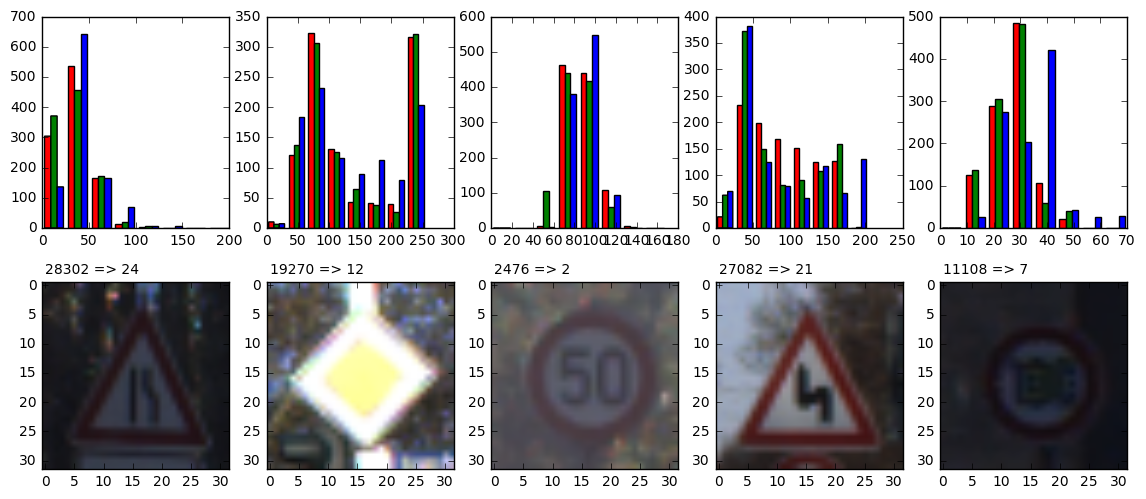

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import numpy as np
import cv2

def plotRandHist(source,index,nx,sp):
    image = source[index].squeeze()
    plt.subplot(2, nx, sp)
    n, bins, patches=plt.hist(np.array(image).reshape((32*32,3)), bins=8, range=(0,image.max()),color=['red','green','blue'])
    plt.subplot(2, nx, nx+sp)
    ax=plt.gca()
    plt.imshow(image)
    ax.text(0,-2,""+str(index)+" => "+str(y_train[index])).draw(ax.figure.canvas.get_renderer())
    return n, bins, patches

plt.figure(figsize=(14,6))

for i in range(1,6):
    index = random.randint(0, len(X_train))
    plotRandHist(X_train,index,5,i)


In [5]:
clahe = cv2.createCLAHE(clipLimit=4.0,tileGridSize=(2,2))

def normalizeImage(image):
    nrmImg=cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    nrmImg[:,:,0]=clahe.apply(nrmImg[:,:,0])
    #nrmImg[:,:,0]=cv2.equalizeHist(nrmImg[:,:,0])
    return (cv2.cvtColor(nrmImg, cv2.COLOR_YUV2RGB))
    #return np.float32(cv2.cvtColor(nrmImg, cv2.COLOR_YUV2RGB)/256.0)

In [6]:
def plotSigns(source,index,ny,nx,sp):
    image = source[index].squeeze()
    plt.subplot(ny*3, nx, (sp-1)*3+1)
    ax=plt.gca()
    plt.imshow(image)
    ax.text(0,-2,""+str(index)+" => "+str(y_train[index])).draw(ax.figure.canvas.get_renderer())

    eh_img1=normalizeImage(image)

    eh_img2 = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    eh_img2[:,:,0] = cv2.equalizeHist(eh_img2[:,:,0])
    eh_img2=cv2.cvtColor(eh_img2, cv2.COLOR_YUV2RGB)

    plt.subplot(ny*3, nx, (sp-1)*3+2)
    plt.imshow(eh_img1)
    plt.subplot(ny*3, nx, (sp-1)*3+3)
    plt.imshow(eh_img2)


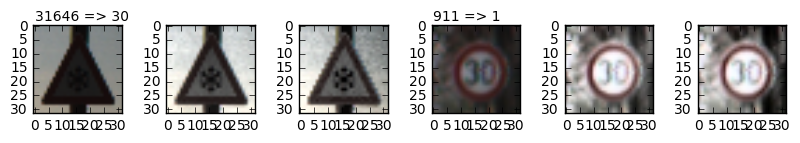

In [7]:
plt.figure(figsize=(10,8))
plotSigns(X_train,31646,2,6,1)
plotSigns(X_train,911,2,6,2)

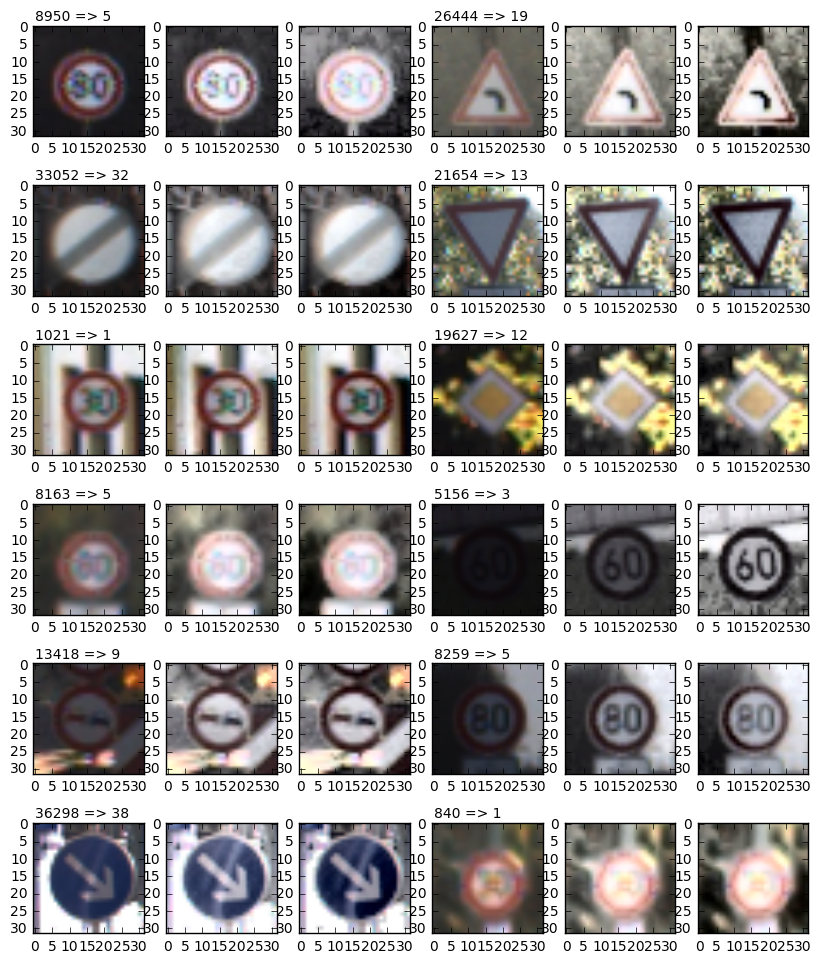

In [8]:
plt.figure(figsize=(10,12))


for i in range(1,13):
    index = random.randint(0, len(X_train))
    plotSigns(X_train,index,2,6,i)



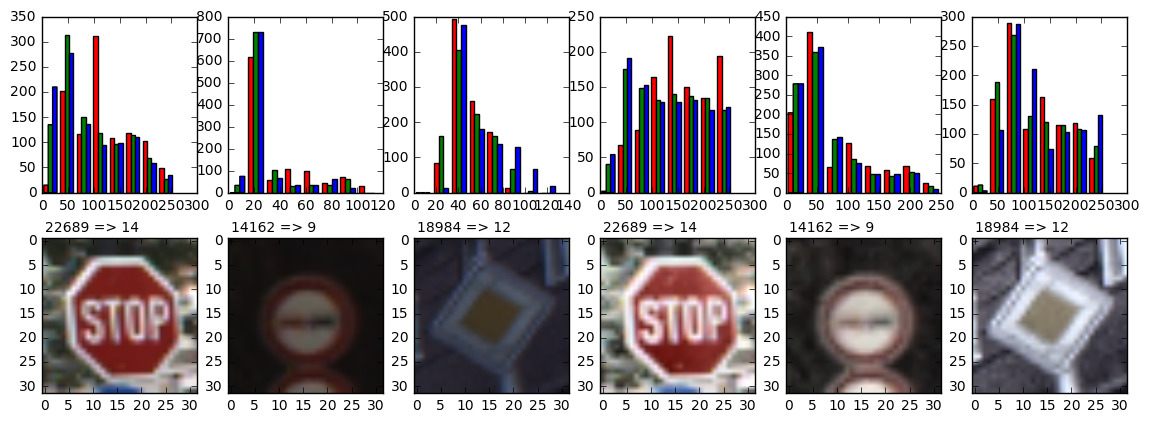

In [9]:
X_train_N=[]
for i in range(len(X_train)):
    X_train_N.append(normalizeImage(X_train[i]))
    
X_test_N=[]
for i in range(len(X_test)):
    X_test_N.append(normalizeImage(X_test[i]))

plt.figure(figsize=(14,5))

for i in range(1,4):
    index = random.randint(0, len(X_train))
    plotRandHist(X_train,index,6,i)
    plotRandHist(X_train_N,index,6,i+3)



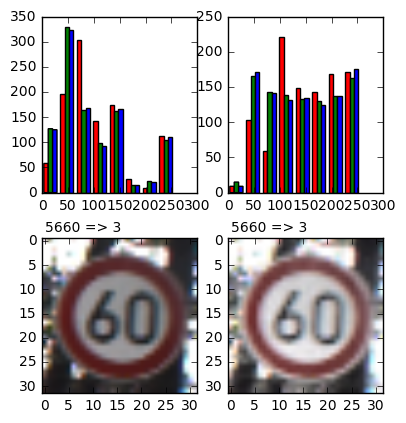

In [10]:
plt.figure(figsize=(14,5))
plotRandHist(X_train, 5660, 6, 1);
plotRandHist(X_train_N, 5660, 6, 2);


### Question 1 

Describe how you preprocessed the data. Why did you choose that technique?

**Answer:**
- increasing contrast, normalizing histogram using clahe from opencv
- 

<Container object of 43 artists>

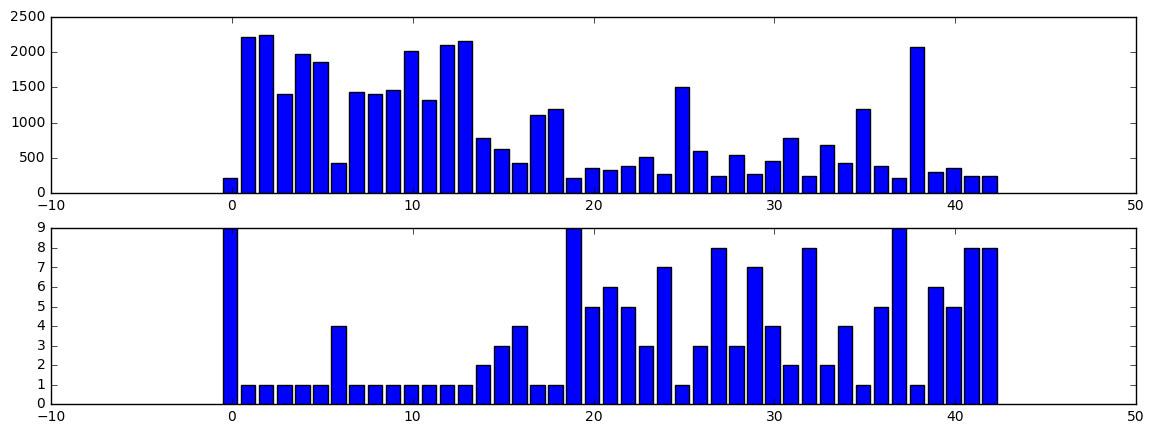

In [11]:
### Generate additional data (OPTIONAL!)
### how many examples per class?
counter = np.zeros(n_classes, np.int32)
factor = np.ones(n_classes, np.int32)
for i in range(len(y_train)):
    counter[y_train[i]]+=1
    
for i in range(n_classes):
    factor[i]=max(2000/counter[i],1)
    
plt.figure(figsize=(14,5))
plt.subplot(2, 1, 1)
plt.bar(np.arange(n_classes)-0.5, counter)
plt.subplot(2, 1, 2)
plt.bar(np.arange(n_classes)-0.5, factor)


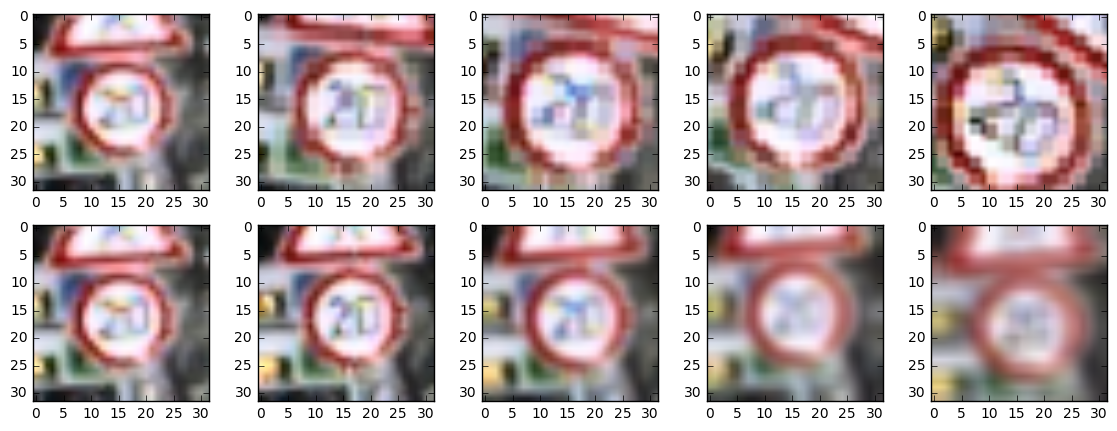

In [12]:
### methods for generating additional data: rotate, blur

import matplotlib.transforms as tr
import scipy
from scipy import misc
import math
from scipy import ndimage

def rotateImage(img, angle):
    if abs(angle)>0:
        padX = [1,1]
        padY=[1,1]
        imgP = np.pad(img, [padY, padX, [0, 0]], 'constant')
        imgR = ndimage.rotate(imgP, angle, reshape=True)
        x=np.int32(imgR.shape[0]/2.0-(32.0/(math.cos(math.pi*abs(angle)/180.)+math.sin(math.pi*abs(angle)/180.)))/2.0+0.5)
        imgR = imgR[x : -x, x : -x]
        z = 32.0/imgR.shape[0]
        img_resize=scipy.ndimage.zoom(imgR, (z, z, 1), order=0)
    else:
        img_resize = img
    return img_resize

def blurImage(img, d):
    if d>0:
        kernel = np.ones((d,d),np.float32)/(d*d)
        return cv2.filter2D(img,-1,kernel)
    else:
        return img
    
plt.figure(figsize=(14,5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    image = X_train_N[i]
    image_rot=rotateImage(image, -i*10)
    plt.imshow(image_rot)

for i in range(5):
    plt.subplot(2, 5, 5+i+1)
    image = X_train_N[i]
    image_rot=blurImage(image, i)
    plt.imshow(image_rot)



In [13]:
def genData(image, number):
    trType=np.array(range(12))
    result=[]
    result.append(image)

    for i in range(number-1):
        idx=np.int32(len(trType)*random.random())
        if trType[idx]<=5:
            if trType[idx]<3:
                angle=(trType[idx]-3)*5
            else:
                angle=(trType[idx]-2)*5
            result.append(rotateImage(image, angle))
            trType=np.delete(trType, idx)
        else:
            result.append(blurImage(image, 3))
            trType=np.delete(trType, range(6-i, 12-i))
        #print(trType)
            
    return result

r=len(X_train_N)
X_train_N_ext=[]
y_train_ext=np.array([], np.uint8)
for i in range(r):
    f=factor[y_train[i]]
    generated=genData(X_train_N[i], min(f,5))
    X_train_N_ext=X_train_N_ext+generated
    y_gen=np.array(np.ones(min(f,5))*y_train[i], np.uint8)
    y_train_ext=np.concatenate((y_train_ext, y_gen))
    
#X_train_N=X_train_Next


<Container object of 43 artists>

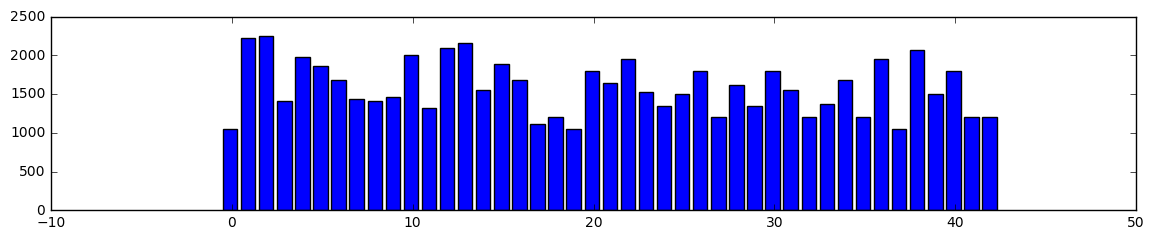

In [14]:
### how many examples per class?
counter = np.zeros(n_classes, np.int32)
for i in range(len(y_train_ext)):
    counter[y_train_ext[i]]+=1
    
plt.figure(figsize=(14,2.5))
plt.bar(np.arange(n_classes)-0.5, counter)


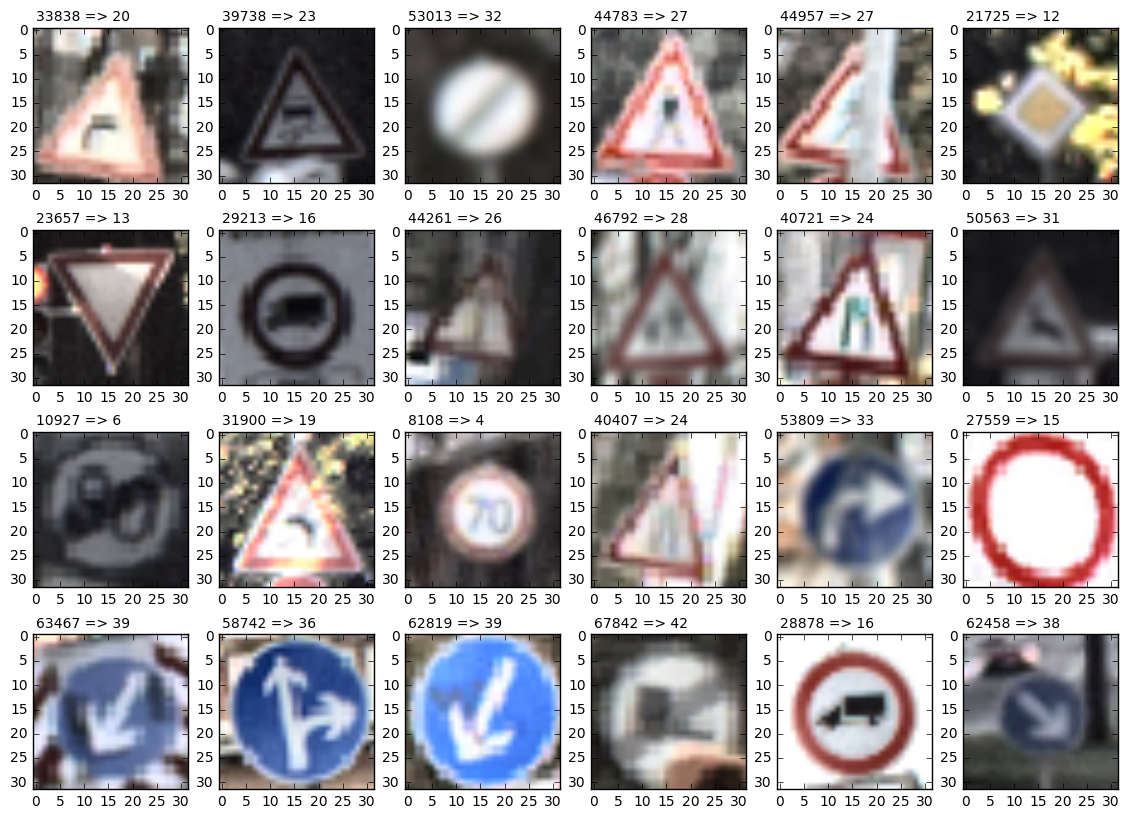

In [15]:
# finally: rescale train and test data to 0..1

X_train_N_resc = np.float32(np.array(X_train_N_ext, np.float32) / 255.0)
X_test_N_resc = np.float32(np.array(X_test_N, np.float32) / 255.0)

plt.figure(figsize=(14,10))
for i in range(1,25):
    plotRandSigns(X_train_N_resc, y_train_ext,4,6,i)


In [16]:
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

#shuffle before split
from sklearn.utils import shuffle

X_train_N_resc, y_train_ext = shuffle(X_train_N_resc, y_train_ext)

# Get randomized datasets for training and validation
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train_N_resc,
    y_train_ext,
    test_size=0.2,
    random_state=832289)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
- additional images by rotating +-5°, 10°, 15° or blurring. Idea: http://bsft.io/x/17vh6w?uid=eb0ca4a3-b31f-4b1e-9a58-7b9f5289dcea&mid=d789410e-7465-4b5f-a6a0-e1045040f254
- rescaling images to 32bit float, numbers from 0..255 to 0.0..1.0
- split training data into 80% training data and 20% validation data

In [17]:
import tensorflow as tf


In [18]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# reusing LeNet
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def fullyconnected(x, W, b):
    fc = tf.add(tf.matmul(x, W), b)
    return fc

def Network(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    layer_depth = {
        'layer_1': 12,
        'layer_2': 28,
        'fully_connected_1': 240,
        'fully_connected_2': 124,
        'n_classes': 43
    }

    weights = {
        'layer_1': tf.Variable(tf.truncated_normal(
            [5, 5, 3, layer_depth['layer_1']], mean=mu, stddev=sigma)),
        'layer_2': tf.Variable(tf.truncated_normal(
            [7, 7, layer_depth['layer_1'], layer_depth['layer_2']], mean=mu, stddev=sigma)),
        'fully_connected_1': tf.Variable(tf.truncated_normal(
            [4*4*28, layer_depth['fully_connected_1']], mean=mu, stddev=sigma)),
        'fully_connected_2': tf.Variable(tf.truncated_normal(
            [layer_depth['fully_connected_1'], layer_depth['fully_connected_2']], mean=mu, stddev=sigma)),
        'n_classes': tf.Variable(tf.truncated_normal(
            [layer_depth['fully_connected_2'], layer_depth['n_classes']], mean=mu, stddev=sigma))
    }
    biases = {
        'layer_1': tf.Variable(tf.zeros(layer_depth['layer_1'])),
        'layer_2': tf.Variable(tf.zeros(layer_depth['layer_2'])),
        'fully_connected_1': tf.Variable(tf.zeros(layer_depth['fully_connected_1'])),
        'fully_connected_2': tf.Variable(tf.zeros(layer_depth['fully_connected_2'])),
        'n_classes': tf.Variable(tf.zeros(layer_depth['n_classes'])),
    }

    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x12.
    conv1=conv2d(x, weights['layer_1'], biases['layer_1'])

    # TODO: Activation.
    # see conv2d

    # TODO: Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1=maxpool2d(conv1)

    # TODO: Layer 2: Convolutional. Output = 8x8x28.
    conv2=conv2d(conv1, weights['layer_2'], biases['layer_2'])
    
    # TODO: Activation.
    # see conv2d

    # TODO: Pooling. Input = 10x10x16. Output = 4x4x28.
    conv2=maxpool2d(conv2)

    # TODO: Flatten. Input = 4x4x28. Output = 448.
    flat=tf.contrib.layers.flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 448. Output = 240.
    fc1=fullyconnected(flat, weights['fully_connected_1'], biases['fully_connected_1'])
    
    # TODO: Activation.
    fc1=tf.nn.softsign(fc1)

    # TODO: Layer 4: Fully Connected. Input = 240. Output = 124.
    fc2=fullyconnected(fc1, weights['fully_connected_2'], biases['fully_connected_2'])
    
    # TODO: Activation.
    fc2=tf.nn.softsign(fc2)

    # TODO: Layer 5: Fully Connected. Input = 124. Output = 43.
    out=fullyconnected(fc2, weights['n_classes'], biases['n_classes'])
    
    return out

In [19]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify traffic sign data.

In [20]:
rate = 0.0005

out = Network(x)
logits=tf.nn.softsign(out)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
- derived from LeNet 5 architecture
    1. first convolution layer takes care about 3 color channels; 5x5x3, output depth 12; activation with relu
    2. 2x2 maxpool reduces to 14x14x12
    3. second conv layer: 7x7x12, output depth 28; activation with relu
    4. 2x2 maxpool reduces to 4x4x28
    5. fully connected 1 outputs 240
    6. activation with softsign
    7. fully connected 2 outputs 124
    8. activation with softsign
    9. fully connected 3 outputs the number of classes 43
    10. for training, also the output layer gets an activation with softsign

- initialisation of weights with mu=0 and sigma=0.1, as in the LeNet-Lab


## Train the Model

Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [22]:
### Train your model here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 250
BATCH_SIZE = 2048

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_split)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_split, y_train_split = shuffle(X_train_split, y_train_split)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_split[offset:end], y_train_split[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_split, y_valid_split)
        print("EPOCH {} ... ".format(i+1)+"Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, 'tsc')
    print("Model saved")

Training...

EPOCH 1 ... Validation Accuracy = 0.348
EPOCH 2 ... Validation Accuracy = 0.518
EPOCH 3 ... Validation Accuracy = 0.604
EPOCH 4 ... Validation Accuracy = 0.672
EPOCH 5 ... Validation Accuracy = 0.713
EPOCH 6 ... Validation Accuracy = 0.735
EPOCH 7 ... Validation Accuracy = 0.752
EPOCH 8 ... Validation Accuracy = 0.771
EPOCH 9 ... Validation Accuracy = 0.778
EPOCH 10 ... Validation Accuracy = 0.790
EPOCH 11 ... Validation Accuracy = 0.802
EPOCH 12 ... Validation Accuracy = 0.814
EPOCH 13 ... Validation Accuracy = 0.826
EPOCH 14 ... Validation Accuracy = 0.839
EPOCH 15 ... Validation Accuracy = 0.849
EPOCH 16 ... Validation Accuracy = 0.858
EPOCH 17 ... Validation Accuracy = 0.862
EPOCH 18 ... Validation Accuracy = 0.869
EPOCH 19 ... Validation Accuracy = 0.874
EPOCH 20 ... Validation Accuracy = 0.882
EPOCH 21 ... Validation Accuracy = 0.885
EPOCH 22 ... Validation Accuracy = 0.885
EPOCH 23 ... Validation Accuracy = 0.891
EPOCH 24 ... Validation Accuracy = 0.900
EPOCH 25 ...

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
- Adam Optimizer
- Batch Size = 2048
- 250 epochs
- learning rate = 0.0005

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
- trial and error playing around with the parameters.
- solution is based on the LeNet-5 architecture. traffic sign classification should be a problem that is closely related to the classification of hand written digits.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

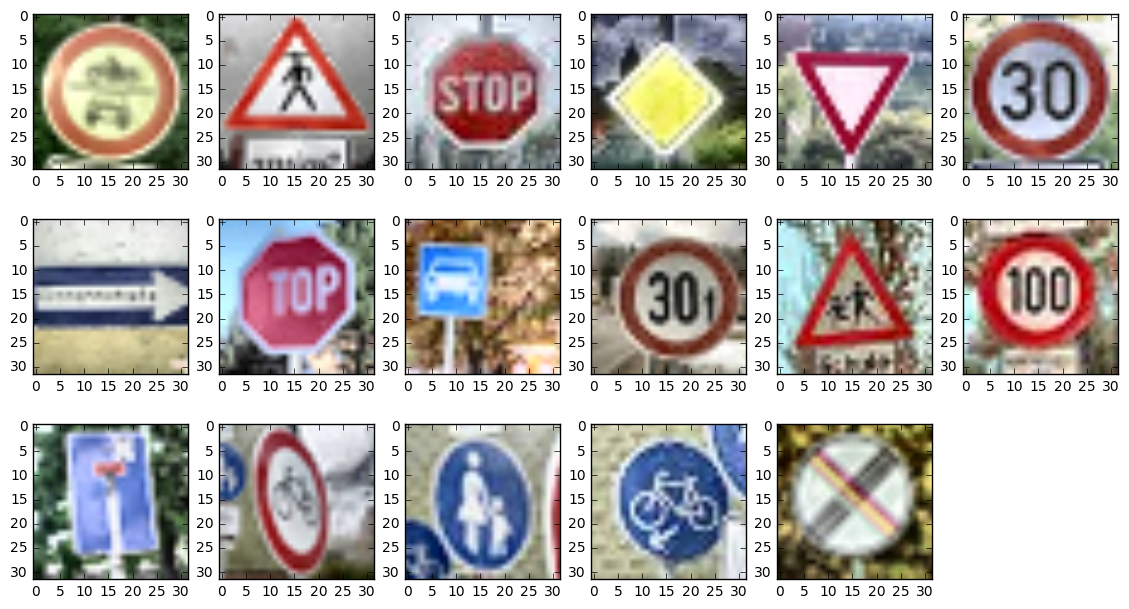

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg

X_check=[]
for idx in range(1,18):
    image = mpimg.imread("../examples/{:02}.png".format(idx))
    X_check.append(image)
    
X_check=np.array(X_check, np.float32)
X_check=X_check*255
X_check=np.uint8(X_check)

X_check[1]=np.fliplr(X_check[1])

X_check_N=[]
for i in range(len(X_check)):
    X_check_N.append(normalizeImage(X_check[i]))
    
X_check_N=np.float32(X_check_N)/255.0

plt.figure(figsize=(14,7.5))
for i in range(len(X_check_N)):
    plt.subplot(3,6,i+1)
    plt.imshow(X_check_N[i])
    
    

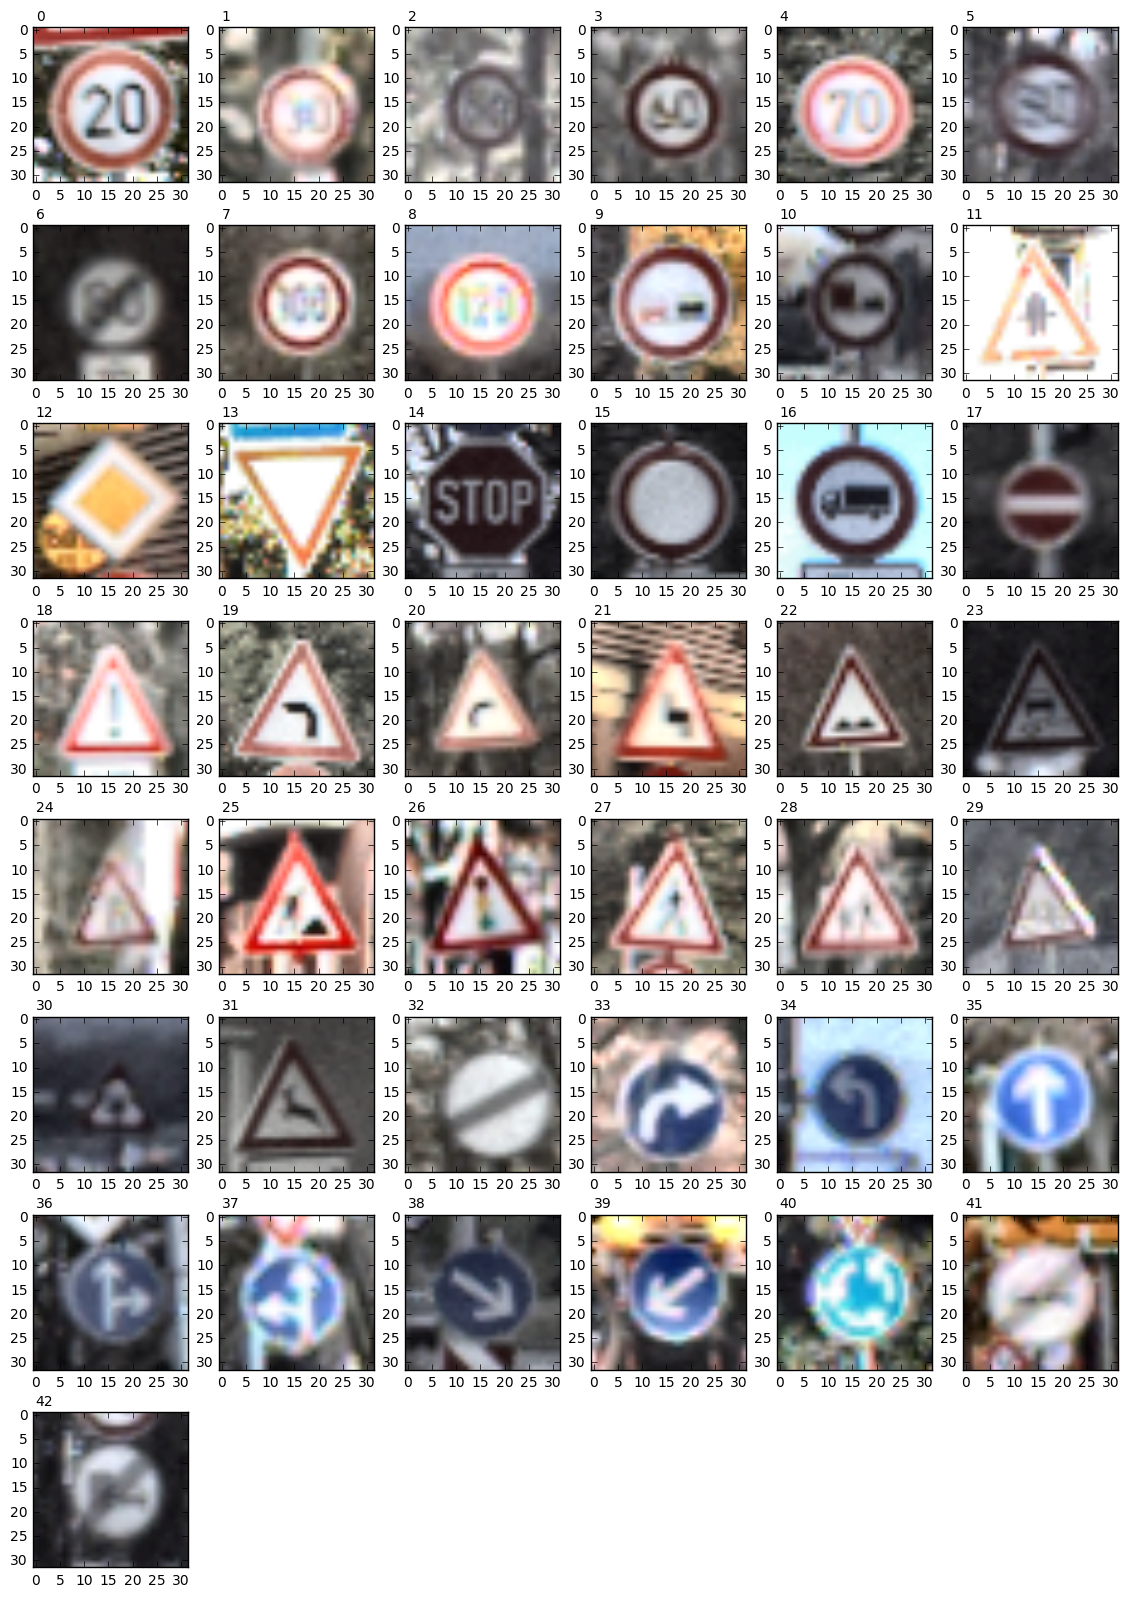

In [24]:
# show a random example of all the 43 classes
ex=np.ones(43, np.int32)*-1
while min(ex)<0:
    idx=random.randint(0, len(y_train))
    if ex[y_train[idx]]<0:
        ex[y_train[idx]]=idx
        
plt.figure(figsize=(14,20))

for i in range(43):
    plt.subplot(8,6,i+1)
    ax=plt.gca()
    plt.imshow(normalizeImage(X_train[ex[i]]))
    ax.text(0,-2,""+str(i)).draw(ax.figure.canvas.get_renderer())


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
- 17 examples
- there are a few images that are not represented in the training data base: index 0, 6, 8, 9, 12, 13, 14, 15. still, looking at the softmax probabilities, the model seems to be very confident about its classification.
- the remaining 10 examples are represented in the training data base. the classification is clearly wrong for index 1, so 1 out of 10. i'm not clear about why this _nice_ image is classified incorrectly. however, uncertainty in terms of entropy is relatively high for the wrong prediction
- it's nice to see that index 16 is classified correctly


In [25]:
def entropy(probs):
    idx=np.where(probs>0)
    lprobs=np.log(probs[idx])
    return abs(np.sum(probs[idx]*lprobs))


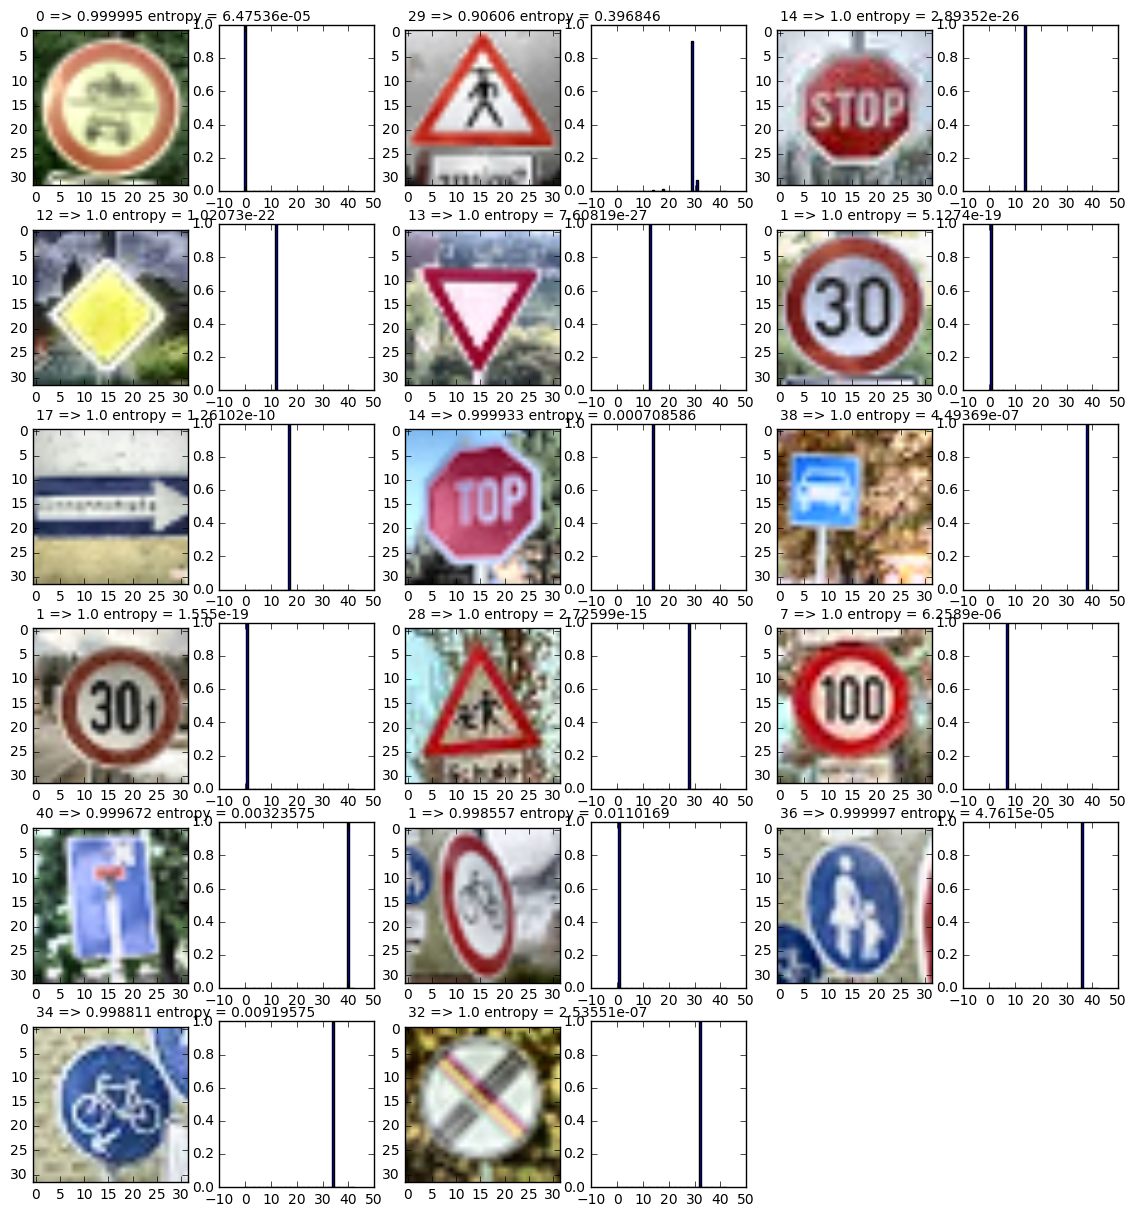

In [26]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

sm=tf.nn.softmax(out)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    prediction = sess.run(sm, feed_dict={x: X_check_N})

### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# for all examples, plot the image, and add a label for the class along with 
# the softmax probability. 
plt.figure(figsize=(14,15))
for i in range(len(prediction)):
    cls=np.where(prediction[i]==max(prediction[i]))
    plt.subplot(6,6,2*i+1)
    ax=plt.gca()
    plt.imshow(X_check_N[i])
    ax.text(0,-2.5,""+str(cls[0][0])+" => "+str(prediction[i,cls][0][0])+" entropy = "+str(entropy(prediction[i]))).draw(ax.figure.canvas.get_renderer())
    plt.subplot(6,6,2*i+2)
    plt.bar(np.arange(n_classes)-0.5, prediction[i])


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
as already stated in the answer to question 6, the accuracy of the predictions on the examples from the internet _that are represented in the training data_ is 90%. This compares to 92.6% of accuracy for the test data (see code section below).

In [27]:

with tf.Session() as sess:

    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_N_resc, y_test)

    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

Test Accuracy = 0.926


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
certainty, or better uncertainty, can be measured using entropy, see below.

the top_k for the two wrong prediction, index 1 (with k=5) do not contain the correct class for index 1 out of the internet examples


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [28]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    tk = sess.run(tf.nn.top_k(sm, k=5), feed_dict={x: X_check_N})


In [29]:
tk.indices

array([[ 0,  4, 17,  8, 29],
       [29, 31, 18, 14, 26],
       [14, 17,  2,  6, 20],
       [12, 32, 15, 17,  7],
       [13, 28, 15,  2, 21],
       [ 1,  0,  2,  6,  4],
       [17, 29, 31, 20,  6],
       [14, 13, 38, 15, 17],
       [38, 34, 13, 29, 28],
       [ 1,  0,  4,  2,  5],
       [28,  8, 29, 11, 20],
       [ 7,  2,  8,  5, 10],
       [40, 35, 39, 28, 20],
       [ 1,  2, 13, 24,  4],
       [36, 38, 34, 26, 39],
       [34, 38, 40, 33,  1],
       [32, 20, 41, 26,  6]], dtype=int32)

In [30]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def eval_entropy(X_data, y_data):
    num_examples = len(X_data)
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        entropies=np.zeros(len(X_data))
        correct = np.zeros(len(X_data))
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            prediction = sess.run(sm, feed_dict={x: batch_x})
            for i in range(len(prediction)):
                entropies[offset+i]=entropy(prediction[i])
                correct[offset+i]=np.argmax(prediction[i])==y_data[offset+i]
        
    return entropies, correct

S, c=eval_entropy(X_test_N_resc, y_test)


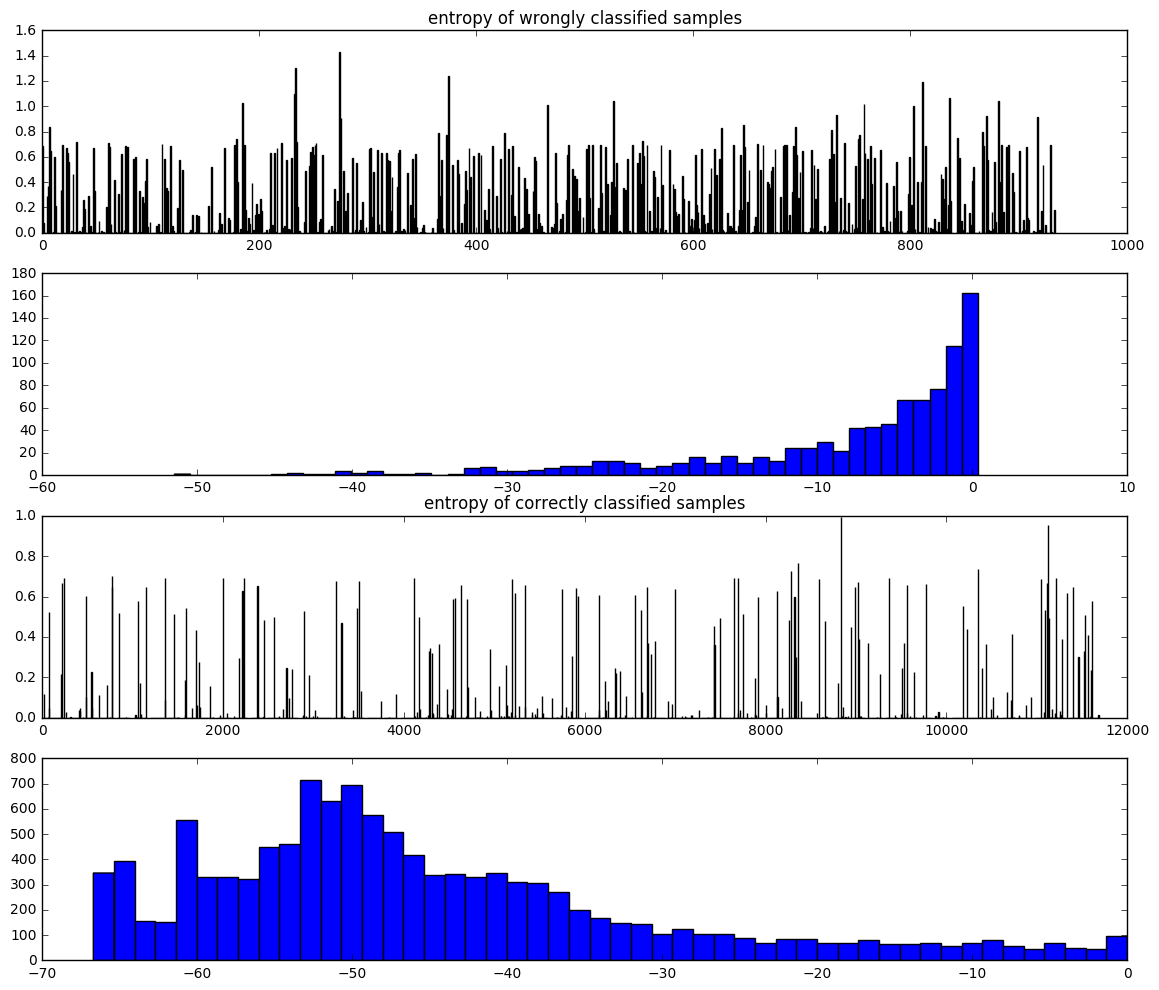

In [31]:
### find examples that are wrongly classified
idxF = np.where(c<0.5)

plt.figure(figsize=(14,12))
plt.subplot(4,1,1)
plt.bar(np.arange(len(idxF[0])), S[idxF[0]])
plt.title('entropy of wrongly classified samples')
plt.subplot(4,1,2)
plt.hist(np.log(S[idxF[0]]), 50);

### find examples that are correctly classified
idxT = np.where(c>0.5)

plt.subplot(4,1,3)
plt.bar(np.arange(len(idxT[0])), S[idxT[0]])
plt.title('entropy of correctly classified samples')
plt.subplot(4,1,4)
plt.hist(np.log(S[idxT[0]]), 50);



Looking at the log of the entropy, comparing the correct and the wrong predictions, it becomes clear that
- the "center of mass" of the histograms is very intuitive: for the wrong predictions, there is high uncertainty, for the correct predictions, there is very low uncertainty
- still there is a high number of wrong predictions with extremely high certainty.